In [49]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [50]:
base_path = "/s/chopin/k/grad/C837304112/Documents/ESML/final_project/human_activity_recognition"
base_path

'/s/chopin/k/grad/C837304112/Documents/ESML/final_project/human_activity_recognition'

In [51]:
uci_har_dataset_path = f'{base_path}/data/UCI_HAR'
uci_har_dataset_path

'/s/chopin/k/grad/C837304112/Documents/ESML/final_project/human_activity_recognition/data/UCI_HAR'

In [52]:
if base_path not in sys.path:
    sys.path.append(base_path) 

In [53]:
import src.load_uci_har_dataset as uci_har

In [54]:
Xtrain, ytrain, xtest, ytest, labels = uci_har.load_uci_har_dir(uci_har_dataset_path)

In [55]:
Xtrain.shape, ytrain.shape, xtest.shape, ytest.shape, labels,len(labels)

((7352, 128, 6),
 (7352,),
 (2947, 128, 6),
 (2947,),
 ['WALKING',
  'WALKING_UPSTAIRS',
  'WALKING_DOWNSTAIRS',
  'SITTING',
  'STANDING',
  'LAYING'],
 6)

In [56]:
import src.get_models as models

In [57]:
input_shape = Xtrain.shape[1:]
num_classes = len(labels)
input_shape, num_classes

((128, 6), 6)

In [58]:
import importlib
importlib.reload(models)

<module 'src.get_models' from '/s/chopin/k/grad/C837304112/Documents/ESML/final_project/human_activity_recognition/src/get_models.py'>

In [59]:
normal_ids = {0, 3, 5}

In [61]:
autoencoder = models.get_autoencoder()

In [62]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [66]:
train_normal_mask = np.isin(ytrain, list(normal_ids))
Xtrain_normal = Xtrain[train_normal_mask]

lr_decay_callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=8, min_lr=1e-6, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

hist = autoencoder.fit(
    Xtrain_normal, Xtrain_normal,
    batch_size=64, epochs=150, validation_split=0.11,
    callbacks=[early_stop, lr_decay_callback], verbose=1
)

Epoch 1/150
55/55 [==============================] - 1s 20ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 2/150
55/55 [==============================] - 1s 21ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 3/150
55/55 [==============================] - 1s 19ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 4/150
55/55 [==============================] - 1s 21ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 5/150
55/55 [==============================] - 1s 19ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 6/150
55/55 [==============================] - 1s 21ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 7/150
55/55 [==============================] - 1s 20ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 8/150
55/55 [==============================] - 1s 22ms/step - loss: 0.0418 - val_loss: 0.0525 - lr: 2.5000e-04
Epoch 9/150
53/55 [===========================>..] - ETA: 0s - l

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [68]:
n_train_norm = len(Xtrain_normal)
cut = int(0.85 * n_train_norm)
Xval = Xtrain_normal[cut:]
Xval_pred = autoencoder.predict(Xval, batch_size=256, verbose=0)
val_err = np.mean((Xval - Xval_pred)**2, axis=(1,2))

q = 98  # percentile -> tune this
threshold = np.percentile(val_err, q)
print(f"Chosen threshold (q={q}%): {threshold:.6f}")

def anomaly_score(ae, X):
    Xhat = ae.predict(X, batch_size=256, verbose=0)
    return np.mean((X - Xhat)**2, axis=(1,2))

scores_test = anomaly_score(autoencoder, xtest)

y_anom_test = (~np.isin(ytest, list(normal_ids))).astype(np.int32)

y_pred = (scores_test > threshold).astype(np.int32)

prec = precision_score(y_anom_test, y_pred, zero_division=0)
rec  = recall_score(y_anom_test, y_pred,  zero_division=0)
f1   = f1_score(y_anom_test, y_pred,     zero_division=0)
cm   = confusion_matrix(y_anom_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print(f"Confusion matrix [[TN FP],[FN TP]]:\n{cm}")
print(f"Anomaly rate (test): {y_pred.mean():.3f}")

Chosen threshold (q=98%): 0.227907
Precision: 0.7755  Recall: 0.0801  F1: 0.1452
Confusion matrix [[TN FP],[FN TP]]:
[[1491   33]
 [1309  114]]
Anomaly rate (test): 0.050


In [72]:
loss = autoencoder.evaluate(xtest, xtest, verbose=1)

93/93 [==============================] - 0s 3ms/step - loss: 0.0655


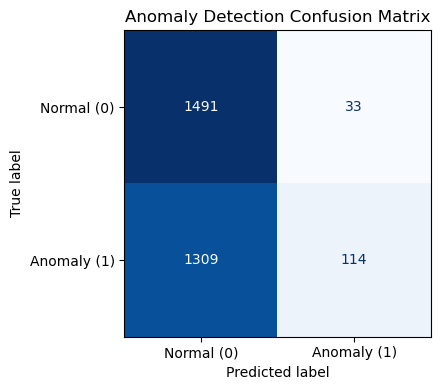

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_anom_test, y_pred, labels=[0, 1])  # [[TN FP],[FN TP]]

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal (0)", "Anomaly (1)"]
)

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.title("Anomaly Detection Confusion Matrix")
plt.tight_layout()
plt.show()
